Reference Solutions for Part 2 Question B: Logistic Regression on BreastMNIST
------------------------------------

Note that some parts of these solutions were inspired by the solutions of Ritwick Jha and Darshan Adiga Haniya Narayana, so thanks (and well done) to them.

Please note, this is just one way to solve the problems, there are many more correct ways to do it, some much better than this!

```
# This is formatted as code
```



In [ ]:
# Install medmnist
!python -m pip install medmnist  &> /dev/null

In [ ]:
# Imports
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils import data as torch_data

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.dummy import DummyClassifier

# For visualizing data
import matplotlib.pyplot as plt
%matplotlib inline

import medmnist



SEED = 99999
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


B1 Data loading and inspection [3 mark]
---------------------------------------

In [ ]:
# get dataset info and data class 
DS_INFO = medmnist.INFO["breastmnist"]
data_class = getattr(medmnist.dataset, DS_INFO["python_class"])
DS_INFO

{'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'label': {'0': 'malignant', '1': 'normal, benign'},
 'license': 'CC BY 4.0',
 'n_channels': 1,
 'n_samples': {'test': 156, 'train': 546, 'val': 78},
 'python_class': 'BreastMNIST',
 'task': 'binary-class',
 'url': 'https://zenodo.org/record/5208230/files/breastmnist.npz?download=1'}

In [ ]:
# apply scaling/flattening transforms to data
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5)), # Normalize the image data
    transforms.Lambda(lambda x: torch.flatten(x)), # Flatten the image
    ])
# note these transforms are only applied when we iterate through the data 
# we can still access the raw data with data_class.imgs

# get the splits 
train_dataset = data_class(split='train', download=True, transform=transform)
val_dataset = data_class(split='val', download=True,  transform=transform)
test_dataset = data_class(split='test', download=True,  transform=transform)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


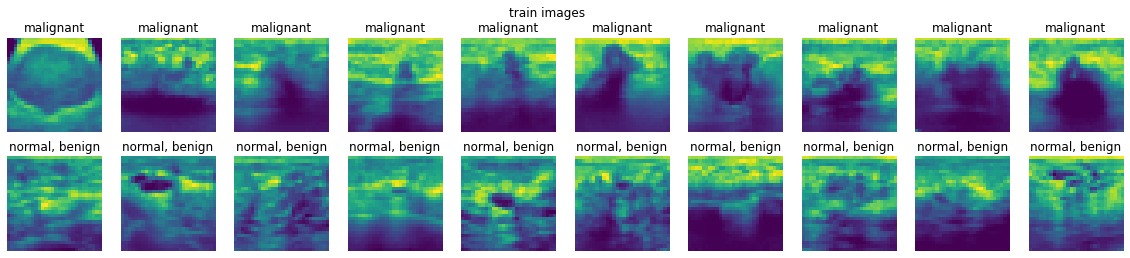

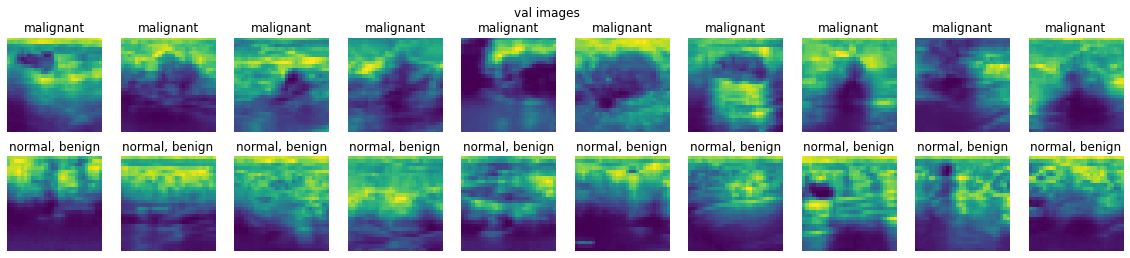

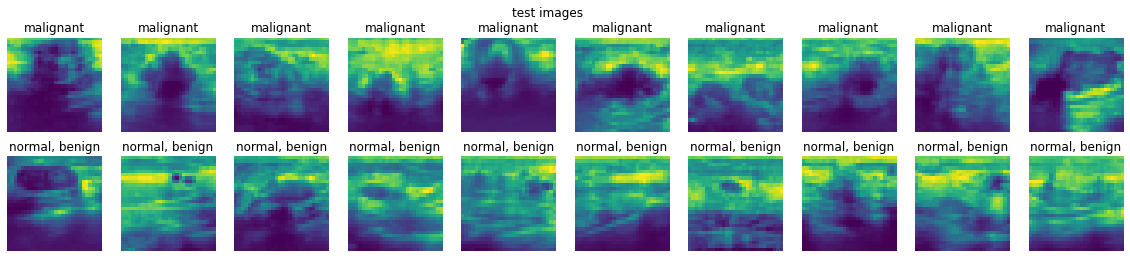

In [ ]:
# define a function for easy plotting
def plot_images(dataset, num=10):
  """
  Plots num images from each of the 2 classes. 
  """
  # get 10 class 0 images 
  class0_imgs = dataset.imgs[dataset.labels[:, 0] == 0][:num]
  # get 10 class 1 images 
  class1_imgs = dataset.imgs[dataset.labels[:, 0] == 1][:num]

  fig, axs = plt.subplots(2, num, figsize=(2*num, 4))
  # add entire plot title 
  plt.suptitle(dataset.split + " images")
  for i in range(num):
    axs[0, i].imshow(class0_imgs[i])
    axs[0, i].axis("off")
    # add each plot title 
    axs[0, i].set_title(DS_INFO["label"]["0"])
    axs[1, i].imshow(class1_imgs[i])
    axs[1, i].axis("off")
    axs[1, i].set_title(DS_INFO["label"]["1"])
  plt.show()

plot_images(train_dataset)
plot_images(val_dataset)
plot_images(test_dataset)    

B2a Logistic regression (sklearn) [2 marks]
-------------------------------------------



In [ ]:
def tensor_to_numpy(data_set):
    """
    helper function to get numpy arrays from data_set
    """
    X = np.array([ex[0].numpy() for ex in data_set])
    y = np.array([ex[1] for ex in data_set])
    return (X, y[:, 0])

In [ ]:
X_train, y_train = tensor_to_numpy(train_dataset)
X_val, y_val = tensor_to_numpy(val_dataset)
X_test, y_test = tensor_to_numpy(test_dataset)

# fit an initial model to check what performence is like 
# remember we should only look at M3 ath the end once we have decided the 
# hyperparams
sk_model = LogisticRegression(solver='sag', penalty='l2', C=1, max_iter=1000)
sk_model.fit(X_train, y_train)
# .score gives the accuracy
print(f"Initial M1: {sk_model.score(X_train, y_train)}")
print(f"Initial M2: {sk_model.score(X_val, y_val)}")

Initial M1: 0.9487179487179487
Initial M2: 0.8461538461538461


In [ ]:

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
# as in the labs, we use predefined split to 
# tell sklearn what is train and what is val data 
fold = np.zeros((np.shape(X_train_val)[0], 1))
fold[0:np.shape(X_train)[0]] = -1
ps = PredefinedSplit(fold)

# generate some Cs, on a log scale
cs = np.logspace(-1, 3, 5)
# also try some different solvers
solvers = ['saga','newton-cg','liblinear']
# make grid
grid = dict(C = cs, solver=solvers)

# run grid search
sk_model = LogisticRegression(penalty = 'l2', max_iter=1000)
sk_gs = GridSearchCV(sk_model, param_grid = grid, cv=ps)
sk_gs.fit(X_train_val, y_train_val)

print("Best C value: ", sk_gs.best_params_)
print("Best M2:", sk_gs.best_score_)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not c

Best C value:  {'C': 1.0, 'solver': 'liblinear'}
Best M2: 0.8846153846153846


In [ ]:
# retrain with best params 
best_sk_model = LogisticRegression(penalty='l2', max_iter=1000,  **sk_gs.best_params_)
best_sk_model.fit(X_train, y_train)
# compute metrics
sk_scores = {}
sk_scores["M1"] = best_sk_model.score(X_train, y_train)
sk_scores["M2"] = best_sk_model.score(X_val, y_val)
sk_scores["M3"] = best_sk_model.score(X_test, y_test)

print("Metrics for best model:")
print(sk_scores)
# compute dummy metrics for a classifier that only predicts the most recent class
# this helps us tell how well our classifier is performing, it needs to be 
# better than the dummy!
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_scores = {}
dummy_scores["M1"] = dummy_model.score(X_train, y_train)
dummy_scores["M2"] = dummy_model.score(X_val, y_val)
dummy_scores["M3"] = dummy_model.score(X_test, y_test)

print("Metrics for dummy model")
print(dummy_scores)


Metrics for best model:
{'M1': 0.9523809523809523, 'M2': 0.8846153846153846, 'M3': 0.7948717948717948}
Metrics for dummy model
{'M1': 0.7307692307692307, 'M2': 0.7307692307692307, 'M3': 0.7307692307692307}


B2b Logistic regression (pytorch) [2 marks]
-------------------------------------------


In [ ]:
batch_size=32
train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class PTLogisticRegression(nn.Module):
    """Pytorch Logistic Regression class"""
    def __init__(self, input_dim):
        super(PTLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.loss_fun = nn.BCELoss()
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
    def fit(self, train_loader, val_dataset, epochs=300, lr=0.001, weight_decay=0.01, verbose=True):
        """Train the model using minibatch AdamW optimizer with weight decay. 
        train_loader: DataLoader object with apprpriate batch sizes
        val_dataset: DataSet object,
        lr: Learning Rate, default=0.01
        weight_decay: Weight decay or L2 penalty, for L2 Regularization. Default=0.01
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Training
        for ep in range(epochs):
            for itr,batch in enumerate(train_loader):
                batch_x,batch_y = batch
                batch_y = batch_y.to(torch.float32)
                # Training steps
                optimizer.zero_grad()
                pred_y = self.forward(batch_x)
                # Compute the cost
                cost = self.loss_fun(pred_y, batch_y)
                # Track the loss
                loss_value = cost.item()
                # Update the parameters
                cost.backward()
                optimizer.step()

            # End of inner for loop, Report the training loss every 10th epoch
            if ep % 100 == 0 and verbose:
                print(f'Epoch:{ep} Val accuracy: {self.score(val_dataset)}')
        

    def predict(self, X):
        """Return class prediction for an example."""
        # Make sure the tensors are detached
        with torch.no_grad():
            preds = self.forward(X)
            preds = preds.round()
            return preds

    def score(self, dataset):
        """Compute the score on a dataset."""
        correct = 0
        # Make sure the tensors are detached
        with torch.no_grad():
          for d in dataset:
            X, y = d
            preds = self.predict(X)
            correct += preds.item() == y
        return (correct/len(dataset))[0]
      

In [ ]:
# fit an initial model to check what performence is like 
# remember we should only look at M3 ath the end once we have decided the 
# hyperparams
pt_model = PTLogisticRegression(784)
pt_model.fit(train_loader, val_dataset)


Epoch:0 Val accuracy: 0.7435897435897436
Epoch:100 Val accuracy: 0.8589743589743589
Epoch:200 Val accuracy: 0.8589743589743589


In [ ]:
print(f"Intial M1: {pt_model.score(train_dataset)}")
print(f"Intial M2: {pt_model.score(val_dataset)}")

Intial M1: 0.8754578754578755
Intial M2: 0.8589743589743589


In [ ]:
# try some different decay values 
wds = np.logspace(-5, -1, 5)
wd_M2s = np.zeros(5)

for i, wd in enumerate(wds):
  print(f"Running weight decay {wd:.5f}...")
  wd_pt_model = PTLogisticRegression(784)
  wd_pt_model.fit(train_loader, val_dataset, weight_decay=wd, verbose=False)  
  # store scores
  wd_M2s[i] = pt_model.score(val_dataset)

# pick the best different decay values 
best_wd = wds[np.argmax(wd_M2s)]
print(f"Best weight decay: {best_wd}")
print(f"Best M2 score: {np.max(wd_M2s)}")

Running weight decay 0.00001...
Running weight decay 0.00010...
Running weight decay 0.00100...
Running weight decay 0.01000...
Running weight decay 0.10000...
Best weight decay: 1e-05
Best M2 score: 0.8589743589743589


In [ ]:
# refit with best decay
best_pt_model = PTLogisticRegression(784)
best_pt_model.fit(train_loader, val_dataset, weight_decay=best_wd)  

pt_scores = {}
# compute metrics
pt_scores["M1"] = best_pt_model.score(train_dataset)
pt_scores["M2"] = best_pt_model.score(val_dataset)
pt_scores["M3"] = best_pt_model.score(test_dataset)

print("Metrics for best model:")
print(pt_scores)

Epoch:0 Val accuracy: 0.7564102564102564
Epoch:100 Val accuracy: 0.8461538461538461
Epoch:200 Val accuracy: 0.8589743589743589
Metrics for best model:
{'M1': 0.8864468864468864, 'M2': 0.8589743589743589, 'M3': 0.7884615384615384}


B3 Performance comparison (2 marks)
-----------------------------------

<Figure size 72x144 with 0 Axes>

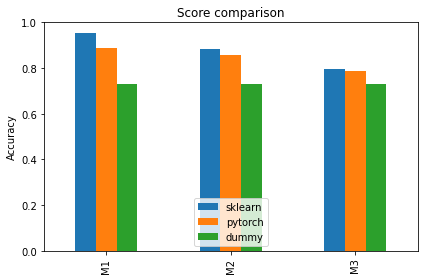

In [ ]:
# pandas makes it easy to plot bar charts 
import pandas as pd
# add to data frame 
scores = pd.DataFrame(columns=["M1", "M2", "M3"])
scores.loc["dummy"] = dummy_scores
scores.loc["pytorch"] = pt_scores
scores.loc["sklearn"] = sk_scores
# this makes it so the metrics are grouped 
scores = scores.T

fig = plt.figure(figsize=(1, 2))
scores.plot( y=["sklearn", "pytorch", "dummy"], kind="bar", fig=fig)
plt.title("Score comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="lower center")
plt.show()

In [ ]:
# all the scores
scores

,dummy,pytorch,sklearn
M1,0.730769,0.886447,0.952381
M2,0.730769,0.858974,0.884615
M3,0.730769,0.788462,0.794872


Observations 
------------

* It is clear that both models are overfitting to the training set to some extent, despite the regularisation.
* It is interesting to note that the scores on the validation set are much higher than the test set. This may indicate that our test and validation sets have diffferent properties.
* The sklearn implementation is highly optimised, so runs many times faster than base pytorch. We could use the GPU to speed up out pytorch code.    